<a href="https://colab.research.google.com/github/funkdub/Pytorch/blob/master/ResNet16_and_34_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
print('Importing ...')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets


import os
import random
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Importing ...


使用datasets 准备数据集，并且将训练集 验证机 以及 测试集准备好。

In [3]:
# 其实就是数据增强操作,在dataloader中使用transforms
train_transforms = transforms.Compose(
[
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32,padding=3),
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
]
)

test_transforms = transforms.Compose(
[
    transforms.ToTensor(),
    transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
]
)

train_data = datasets.CIFAR10('data',train=True,download=True,transform=train_transforms)
test_data = datasets.CIFAR10('data',train=False,download=True,transform=test_transforms)

n_train = int(len(train_data)*0.9)
n_valid = len(train_data) - n_train

train_data,valid_data = torch.utils.data.random_split(train_data,[n_train,n_valid])

print('train_data num is',n_train,'|valid_data numm is ',n_valid,'|test_data numm is',len(test_data))

0it [00:00, ?it/s]

170500096it [00:02, 84766877.46it/s]                               


Files already downloaded and verified
train_data num is 45000 |valid_data numm is  5000 |test_data numm is 10000


torch.Size([3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


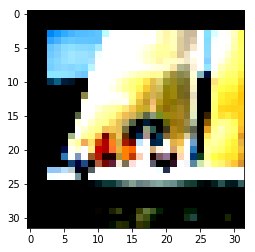

In [4]:
import matplotlib.pyplot as plt
import numpy as np
x = next(iter(train_data))

def show(img):
  img = img.numpy()
  plt.imshow(np.transpose(img,(1,2,0)))
  
print(x[0].shape)
grid = torchvision.utils.make_grid(x[0],nrow=10,padding=100)

show(grid)
show(x[0])

参数

In [0]:
BATCH_SIZE = 64

train_data_it = data.DataLoader(train_data, shuffle=True, batch_size = BATCH_SIZE)
valid_data_it = data.DataLoader(valid_data, batch_size = BATCH_SIZE)
test_data_it = data.DataLoader(test_data, batch_size = BATCH_SIZE)


定义 ResNet Block

In [0]:
class ResNetBlock(nn.Module):
  def __init__(self,in_channels,out_channels,stride):
    super().__init__()
    
    self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=stride,padding=1,bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)
    
    
    self.downsample = nn.Sequential() 
    if stride !=1 or in_channels != out_channels:
      self.downsample = nn.Sequential(
          nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False),
          nn.BatchNorm2d(out_channels)
      )
    
         
   
  def forward(self,x0):
    x = F.relu(self.bn1(self.conv1(x0)))
    x = self.bn2(self.conv2(x))
    x += self.downsample(x0)
    x = F.relu(x)
    return x


ResNet Layer

In [0]:
class ResNetLayer(nn.Module):
  def __init__(self, block, n_blocks, in_channels, out_channels, stride):
    super().__init__()
    
    self.modules = []
    
    self.modules.append(block(in_channels,out_channels,stride))
    
    for _ in range(n_blocks - 1):
      self.modules.append(block(out_channels,out_channels,1))     
      
    self.blocks = nn.Sequential(*self.modules)
    
  def forward(self,x):
    return self.blocks(x)

ResNet18

In [0]:
class ResNet18(nn.Module):
  def __init__(self,layer,block):
    super().__init__()
    
    n_blocks = [2,2,2,2]
    
    self.conv1 = nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = layer(block , n_blocks[0], 64, 64 ,1)
    self.layer2 = layer(block , n_blocks[1], 64, 128 ,2)    
    self.layer3 = layer(block , n_blocks[2], 128, 256 ,2)
    self.layer4 = layer(block , n_blocks[3], 256, 512 ,2)
    self.fc1 = nn.Linear(512, 10)
    
  def forward(self,x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = F.avg_pool2d(x , 4)
    x = x.view(x.shape[0],-1)
    x = self.fc1(x)
    return x


ResNet34

In [0]:
class ResNet34(nn.Module):
  def __init__(self,layer,block):
    super().__init__()
    
    n_blocks  = [3,4,6,3]
    
    self.conv1 = nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = layer(block , n_blocks[0], 64, 64 ,1)
    self.layer2 = layer(block , n_blocks[1], 64, 128 ,2)    
    self.layer3 = layer(block , n_blocks[2], 128, 256 ,2)
    self.layer4 = layer(block , n_blocks[3], 256, 512 ,2)
    self.fc1 = nn.Linear(512, 10)
    
  def forward(self,x):
    x = F.relu(self.bn1(self.conv1(x)))
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = F.avg_pool2d(x , 4)
    x = x.view(x.shape[0],-1)
    x = self.fc1(x)
    return x


In [10]:
BATCH_NORM = True

def get_n_parameters(model):
  return sum([p.numel() for p in model.parameters()])


resnet18_model = ResNet18(ResNetLayer, ResNetBlock)
resnet18_parameters = get_n_parameters(resnet18_model)

resnet34_model = ResNet34(ResNetLayer, ResNetBlock)
resnet34_parameters = get_n_parameters(resnet34_model)


print('R18 param num is ', resnet18_parameters)
print('R34 param num is ', resnet34_parameters)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = ResNet34(ResNetLayer,ResNetBlock).to(device)
optimizer = optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()
print(model)

R18 param num is  11173962
R34 param num is  21282122
cuda
ResNet34(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): ResNetLayer(
    (blocks): Sequential(
      (0): ResNetBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (downsample): Sequential()
      )
      (1): ResNetBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_siz

计算准确率

In [0]:
def accuracy_cal(pred, y):
  # tensor.max选取 tensor中的最大值 
  # max(1)将 最大值的 index 作为结果输出
  prediction = pred.max(1)[1]
  correct = prediction.eq(y.view_as(prediction)).sum()
  acc = correct.float() / prediction.shape[0]
  return acc

In [0]:
def train(model, device , data , optimizer , loss_func):
  epoch_loss = 0
  epoch_acc = 0
  
  model.train()
  
  for (x,y) in data:
    
    x = x.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    pred = model(x)
    loss = loss_func(pred, y)
    acc = accuracy_cal(pred,y)
    loss.backward()
    optimizer.step()
    
    # item()将单值tensor转换成标量
    epoch_loss += loss.item()
    epoch_acc += acc.item()
  return epoch_loss / len(data), epoch_acc / len(data)

In [0]:
def test(model,device,data,loss_func):
  epoch_loss = 0
  epoch_acc = 0
  model.eval()
  
  with torch.no_grad():
    for (x,y) in data:
      x = x.to(device)
      y = y.to(device)
      
      pred = model(x)
      loss = loss_func(pred,y)
      acc = accuracy_cal(pred,y)
      
      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(data), epoch_acc / len(data)
      

In [14]:
EPOCH = 10
SAVE_DIR = 'models'
MODEL_SAVE_DIR = os.path.join(SAVE_DIR,'ResNet_cifar10.pt')

best_valid_loss = float('inf')


if not os.path.isdir(f'{SAVE_DIR}'):
  os.makedirs(f'{SAVE_DIR}')
  
for epoch in range(EPOCH):
  print('Epoch is ',epoch)
  train_loss , train_acc = train(model,device,train_data_it,optimizer,loss_func)
  valid_loss , valid_acc = test(model,device,valid_data_it,loss_func)
  
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(),MODEL_SAVE_DIR)
  print('|EPOCH ',epoch,'|Train Loss is ',train_loss,'|Train Acc is ',train_acc,'|Valid Loss is ',valid_loss,'|Valid acc is ',valid_acc)

Epoch is  0
|EPOCH  0 |Train Loss is  1.642992772331292 |Train Acc is  0.3836115056818182 |Valid Loss is  1.4229607008680512 |Valid acc is  0.4752768987341772
Epoch is  1
|EPOCH  1 |Train Loss is  1.1898646558719603 |Train Acc is  0.5691361860795454 |Valid Loss is  1.0269970991943456 |Valid acc is  0.6350870253164557
Epoch is  2
|EPOCH  2 |Train Loss is  0.9392027310519055 |Train Acc is  0.66796875 |Valid Loss is  0.8808522994005228 |Valid acc is  0.698378164556962
Epoch is  3
|EPOCH  3 |Train Loss is  0.7819979428313673 |Train Acc is  0.7252308238636364 |Valid Loss is  0.7303179943863349 |Valid acc is  0.7436708860759493
Epoch is  4
|EPOCH  4 |Train Loss is  0.6647465413182296 |Train Acc is  0.7670454545454546 |Valid Loss is  0.6896018559419657 |Valid acc is  0.7616693037974683
Epoch is  5
|EPOCH  5 |Train Loss is  0.5826569815504957 |Train Acc is  0.7983620383522727 |Valid Loss is  0.5975852186166788 |Valid acc is  0.7958860759493671
Epoch is  6
|EPOCH  6 |Train Loss is  0.5234556802

In [15]:
model.load_state_dict(torch.load(MODEL_SAVE_DIR))
test_loss, test_acc = test(model,device,test_data_it,loss_func)
print('Test Loss is ',test_loss,'|Test ACC is ',test_acc)

Test Loss is  0.396747120721325 |Test ACC is  0.8702229299363057
